C:\Users\krono\AppData\Local\Temp\ipykernel_15180\3473614032.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, connection)


ADF Statistic: -5.897046588902521
p-value: 2.8352666579139207e-07


d:\Setup\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Setup\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
d:\Setup\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\Setup\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


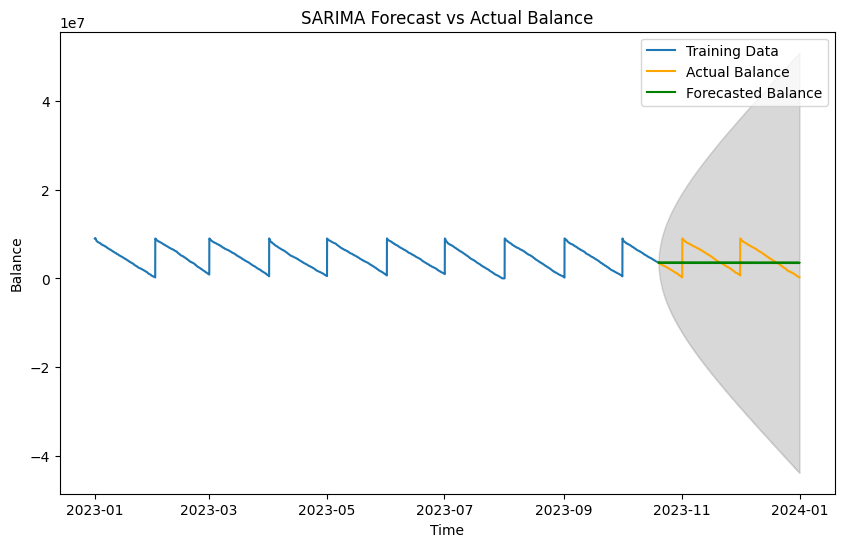

                                     SARIMAX Results                                      
Dep. Variable:                            balance   No. Observations:                 7008
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -99046.033
Date:                            Sun, 18 Aug 2024   AIC                         198102.067
Time:                                    10:50:54   BIC                         198136.332
Sample:                                01-01-2023   HQIC                        198113.874
                                     - 10-19-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0017    172.997   9.63e-06      1.000    -339.067     339.070
ma.L1         -0.0031    172.962  -

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller

# Parameters for MySQL connection
from config import mysql_user, mysql_password, mysql_host, mysql_port, mysql_db

# Connect to the MySQL database
connection = pymysql.connect(host=mysql_host,
                             user=mysql_user,
                             password=mysql_password,
                             database=mysql_db,
                             port=mysql_port)

# Query data for ATM_ID=1
query = "SELECT time, balance FROM atm_balance WHERE ATM_ID=1 ORDER BY time"
df = pd.read_sql(query, connection)

# Close the database connection
connection.close()

# Ensure 'time' is in datetime format and set it as index
df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

# Check for stationarity
result = adfuller(df['balance'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If the data is not stationary, apply differencing
if result[1] > 0.05:
    df['balance_diff'] = df['balance'].diff().dropna()
    data_to_use = df['balance_diff'].dropna()
else:
    data_to_use = df['balance']

# Split data into train and test (80% train, 20% test)
train_size = int(len(data_to_use) * 0.8)
train, test = data_to_use.iloc[:train_size], data_to_use.iloc[train_size:]

# Fit SARIMA model on training data
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# Forecast on test data
forecast = sarima_fit.get_forecast(steps=len(test))
forecasted_balance = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot actual vs forecasted values
plt.figure(figsize=(10, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Balance', color='orange')
plt.plot(test.index, forecasted_balance, label='Forecasted Balance', color='green')
plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], 
                 color='gray', alpha=0.3)
plt.title('SARIMA Forecast vs Actual Balance')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()
plt.show()

# Print model summary
print(sarima_fit.summary())

In [19]:
# forecast = sarima_fit.get_forecast(steps=len(test))
# forecasted_balance = forecast.predicted_mean
# confidence_intervals = forecast.conf_int()
temp = pd.DataFrame(forecasted_balance)
temp['predicted_mean'] = temp['predicted_mean'].astype(int)
print('\nforecast length:', len(temp))
print('\n', temp.head(), '\n', temp.tail())



forecast length: 1752

                      predicted_mean
2023-10-20 00:00:00         3541189
2023-10-20 01:00:00         3529485
2023-10-20 02:00:00         3517292
2023-10-20 03:00:00         3502281
2023-10-20 04:00:00         3487296 
                      predicted_mean
2023-12-31 19:00:00         3569432
2023-12-31 20:00:00         3558803
2023-12-31 21:00:00         3548013
2023-12-31 22:00:00         3539296
2023-12-31 23:00:00         3531377
